# **RBFNN predictive model generation for control systems**

This notebook provides a widget-driven implementation for generating and benchmarking Radial Basis Function Neural Networks (RBFNNs) as predictive models for control applications. The workflow supports:
- data visualization
- signal normalization and time-series feature construction (past-value embedding)
- training multiple candidate RBFNNs across selected fuzzy subset counts
- Train/Validation/Test evaluation with visualization and R² reporting
- model export to `.mat` for integration in downstream optimization/control layers

Implemented within **Greece4.0: Network of Excellence for Digital Transformation Technologies in the Greek Manufacturing Industry**.

**Code repository:**  
https://github.com/ntua-unit-of-control-and-informatics/Predictive-Control-System-Greece4.0/tree/main


## **Code**

In [9]:
## ----------------------------------------------------------------------------
##                                  IMPORT PACKAGES
## ----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
import time as tm
from collections import deque
from tabulate import tabulate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.io import savemat
import os, glob, io, re, joblib, math, textwrap
from google.colab import files

## ----------------------------------------------------------------------------
##                                  IMPORT DATA
## ----------------------------------------------------------------------------

def import_files_widget():
    btn_import = widgets.Button(
        description="Import files",
        style={"button_color": "lightsteelblue"},  # config gray
        layout=widgets.Layout(width="220px")
    )
    status = widgets.HTML()
    out = widgets.Output()

    def on_import(_):
        with out:
            clear_output()
            status.value = "<i>Select files to upload…</i>"

            new_files = files.upload()

            if not new_files:
                status.value = "<b style='color:#A2142F'>❌ No files uploaded.</b>"
                return

            # Merge with existing uploads if present
            if "uploaded" in globals():
                globals()["uploaded"].update(new_files)
            else:
                globals()["uploaded"] = new_files

            status.value = f"<b style='color:#006666'>✅ Imported {len(new_files)} file(s).</b>"

            print("Files available:")
            for k in globals()["uploaded"].keys():
                print(" •", k)

    btn_import.on_click(on_import)

    display(
        widgets.VBox([
            # widgets.HTML("<h3 style='margin:0'>Import files</h3>"),
            btn_import,
            status
        ]),
        out
    )

# Helper: parse "Input: something (unit)" safely
def parse_col(colname: str):
    s = str(colname).strip()

    # label: part after ":" if present, else whole string
    if ":" in s:
        label_part = s.split(":", 1)[1].strip()
    else:
        label_part = s

    # unit: first (...) if present
    m = re.search(r"\((.*?)\)", s)
    unit = m.group(1).strip() if m else None

    # label: remove "(...)" from label_part if it includes it
    label = re.sub(r"\(.*?\)", "", label_part).strip()

    return label, unit

import ipywidgets as widgets
from IPython.display import display, clear_output

def make_open_folder_loader_button(parse_col, folder="/content", index_col=0):
    btn_open = widgets.Button(
        description="Open dataset loader",
        style={"button_color": "lightsteelblue"},
        layout=widgets.Layout(width="220px")
    )
    status = widgets.HTML()
    out = widgets.Output()

    def on_open(_):
        with out:
            clear_output()
            try:
                status.value = "<i>Opening dataset loader…</i>"
                # call your existing function (it will raise if no files)
                load_data_from_folder_widget(parse_col, folder=folder, index_col=index_col)
                status.value = "<b style='color:#006666'>✅ Dataset loader ready.</b>"
            except Exception as e:
                status.value = f"<b style='color:#A2142F'>❌ {e}</b>"

    btn_open.on_click(on_open)

    display(
        widgets.VBox([
            # widgets.HTML("<h3 style='margin:0'>Select dataset from folder</h3>"),
            btn_open,
            status
        ]),
        out
    )

def load_data_from_folder_widget(parse_col, folder="/content", index_col=0):
    """
    Safer loader: lists CSV/XLSX files that actually exist in `folder`,
    lets you pick one, loads it, parses Input/Output columns, validates time,
    and exports globals used by the RBF pipeline.
    """

    def list_data_files():
        patterns = ["*.csv", "*.xlsx", "*.xls"]
        files = []
        for p in patterns:
            files.extend(glob.glob(os.path.join(folder, p)))
        files = sorted(files)
        return files

    files = list_data_files()
    if len(files) == 0:
        raise ValueError(f"No .csv/.xlsx/.xls files found in: {folder}")

    # UI
    w_file = widgets.Dropdown(
        options=files,
        description="File",
        layout=widgets.Layout(width="700px")
    )
    btn_refresh = widgets.Button(description="Refresh list", button_style="")
    btn_load = widgets.Button(description="Load dataset", button_style="success")
    out = widgets.Output()
    status = widgets.HTML()

    def refresh(_):
        with out:
            clear_output()
            new_files = list_data_files()
            if len(new_files) == 0:
                status.value = f"<b style='color:#A2142F'>No data files found in {folder}</b>"
                w_file.options = []
            else:
                status.value = f"<b style='color:#006666'>Found {len(new_files)} file(s).</b>"
                w_file.options = new_files
                if w_file.value not in new_files:
                    w_file.value = new_files[0]

    def validate_time(time_arr):
        bad_idx = np.where([not str(v).replace('.', '', 1).isdigit() for v in time_arr])[0]
        return bad_idx

    def on_load(_):
        with out:
            clear_output()
            status.value = "<i>Loading dataset…</i>"

            filepath = w_file.value
            if not filepath or not os.path.exists(filepath):
                status.value = "<b style='color:#A2142F'>Selected file not found.</b>"
                return

            ext = os.path.splitext(filepath)[1].lower()

            # Read
            if ext in [".xlsx", ".xls"]:
                df_local = pd.read_excel(filepath, index_col=index_col)
            elif ext == ".csv":
                df_local = pd.read_csv(filepath, index_col=index_col)
                # Drop empty columns created by trailing delimiters
                df_local = df_local.dropna(axis=1, how="all")
            else:
                status.value = ""
                raise ValueError(f"Unsupported file type: {ext}")

            # Parse columns
            input_indices, output_indices = [], []
            input_labels, output_labels = [], []
            input_units, output_units = [], []

            for i, col in enumerate(df_local.columns):
                col_str = str(col).strip()
                lower = col_str.lower()

                if "input" in lower:
                    input_indices.append(i)
                    lab, unit = parse_col(col_str)
                    input_labels.append(lab)
                    input_units.append(unit)
                elif "output" in lower:
                    output_indices.append(i)
                    lab, unit = parse_col(col_str)
                    output_labels.append(lab)
                    output_units.append(unit)

            input_indices = np.array(input_indices, dtype=int)
            output_indices = np.array(output_indices, dtype=int)

            num_inputs = len(input_indices)
            num_outputs = len(output_indices)

            # Extract data
            time = df_local.index.values
            inputs = df_local.iloc[:, input_indices].values if num_inputs else np.empty((len(df_local), 0))
            outputs = df_local.iloc[:, output_indices].values if num_outputs else np.empty((len(df_local), 0))
            initial_steady_state = df_local.iloc[0, input_indices].values if num_inputs else np.array([])

            # Validate time
            bad_idx = validate_time(time)
            if len(bad_idx) > 0:
                print(f"⚠️ Invalid time values at indices: {bad_idx[:10]}")
                print(f"Invalid values: {time[bad_idx[:10]]}")
                status.value = f"<b style='color:#A2142F'>Loaded with warnings:</b> {os.path.basename(filepath)}"
            else:
                status.value = f"<b style='color:#006666'>Loaded:</b> {os.path.basename(filepath)}"

            # Export globals
            globals().update({
                "df": df_local,
                "time": time,
                "inputs": inputs,
                "outputs": outputs,
                "num_inputs": num_inputs,
                "num_outputs": num_outputs,
                "input_labels": input_labels,
                "output_labels": output_labels,
                "input_units": input_units,
                "output_units": output_units,
                "initial_steady_state": initial_steady_state,
                "loaded_filepath": filepath
            })

            display(df_local.head(5))

    btn_refresh.on_click(refresh)
    btn_load.on_click(on_load)

    display(
        widgets.VBox([
            widgets.HTML(f"<h3 style='margin:0'>Load dataset from folder</h3><div style='color:#555'>Folder: {folder}</div>"),
            widgets.HBox([w_file, btn_refresh]),
            btn_load,
            status
        ]),
        out
    )


## ----------------------------------------------------------------------------
##                              VISUALIZE DATA
## ----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_inputs_outputs(time, inputs, outputs,
                        input_labels, output_labels,
                        input_units, output_units):
    """
    Plot all inputs followed by all outputs in a single column figure.
    """

    num_inputs = inputs.shape[1]
    num_outputs = outputs.shape[1] if outputs.ndim > 1 else 1
    num_rows = num_inputs + num_outputs
    num_cols = 1

    plt.figure(figsize=(12, num_rows * 3))

    # Colors
    num_colors = num_rows
    colors = sns.color_palette("icefire", num_colors)

    # ---- Inputs ----
    for i in range(num_inputs):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(
            time, inputs[:, i],
            linewidth=1.5, linestyle='-', marker='none',
            color=colors[i % len(colors)]
        )
        plt.title(f"Input {i + 1}", fontsize=11, fontweight='bold')
        plt.ylabel(f"({input_units[i]})", fontsize=10, fontweight='bold')
        plt.legend([input_labels[i]], loc='upper right', fontsize=9)
        plt.xlim(time[0], time[-1])

    # ---- Outputs ----
    for i in range(num_outputs):
        row_idx = i + num_inputs
        y = outputs if outputs.ndim == 1 else outputs[:, i]

        plt.subplot(num_rows, num_cols, row_idx + 1)
        plt.plot(
            time, y,
            linewidth=1.5, linestyle='-', marker='none',
            color=colors[row_idx % len(colors)]
        )
        plt.title(f"Output {i + 1}", fontsize=11, fontweight='bold')
        plt.ylabel(f"({output_units[i]})", fontsize=10, fontweight='bold')
        plt.legend([output_labels[i]], loc='upper right', fontsize=9)
        plt.xlim(time[0], time[-1])

    plt.tight_layout()
    plt.show()

def visualize_data_widget():
    btn_plot = widgets.Button(
        description="Data Visualization",
        button_style="info",
        style={"button_color": "#6B7280"},  # config gray
    )
    out = widgets.Output()

    def on_click(_):
        with out:
            clear_output()

            required = ["time", "inputs", "outputs",
                        "input_labels", "output_labels",
                        "input_units", "output_units"]
            missing = [v for v in required if v not in globals()]
            if missing:
                print("❌ Missing required variables:", missing)
                print("Load data first.")
                return

            plot_inputs_outputs(
                time=time,
                inputs=inputs,
                outputs=outputs,
                input_labels=input_labels,
                output_labels=output_labels,
                input_units=input_units,
                output_units=output_units
            )

    btn_plot.on_click(on_click)

    display(
        widgets.VBox([
            # widgets.HTML("<h3 style='margin:0'>Data visualization</h3>"),
            btn_plot
        ]),
        out
    )

## ----------------------------------------------------------------------------
##                              PREPROCESS DATA
## ----------------------------------------------------------------------------

# Scale data
def scale_data(inputs, outputs):
    xmin = np.min(inputs, axis=0); xmax = np.max(inputs, axis=0)
    ymin = np.min(outputs, axis=0); ymax = np.max(outputs, axis=0)

    X_scaled = 2 * (inputs - xmin) / (xmax - xmin) - 1
    y_scaled = 2 * (outputs - ymin) / (ymax - ymin) - 1

    scaling_x = np.array([xmin, xmax])
    scaling_y = np.array([ymin, ymax])

    return X_scaled, y_scaled, scaling_x, scaling_y


# Structure data into timeseries with pv values
def structure_data(array, pv):
    ninputs = array.shape[1]
    deques = [deque(array[0, i] * np.ones(pv)) for i in range(ninputs)]

    nsamples = array.shape[0]
    x = np.zeros((nsamples, pv * ninputs))

    for k in range(nsamples):
        for i in range(ninputs):
            deques[i].appendleft(array[k, i])
            deques[i].pop()
        x[k, :] = np.concatenate([list(dq) for dq in deques])

    return x


# Split plot (pie)
def plot_data_split(train_pct, val_pct):
    import matplotlib.pyplot as plt

    test_pct = 100 - (train_pct + val_pct)

    labels = ["Training", "Validation", "Test"]
    sizes = [train_pct, val_pct, test_pct]
    colors = ["#142B8C", "#A2142F", "#006666"]

    fig, ax = plt.subplots(figsize=(3.8, 3.8))
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=lambda p: f"{p:.0f}%",
        startangle=90,
        counterclock=False,
        wedgeprops=dict(edgecolor="white", linewidth=1.5),
        textprops=dict(color="black", fontsize=11)
    )
    for at in autotexts:
        at.set_color("white")
        at.set_fontsize(11)
        at.set_fontweight("bold")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()


# Widget panel (preprocess params)
ui_pre = widgets.VBox([
    widgets.HTML("<h3 style='margin:0'>Training Parameters</h3>"),
])

w_pre_train = widgets.FloatSlider(
    value=70, min=0, max=100, step=1,
    description='Train %', continuous_update=False, readout_format='.0f',
    layout=widgets.Layout(width='260px')
)
d_pre_train = widgets.HTML("Percentage of samples used for training.")

w_pre_val = widgets.FloatSlider(
    value=15, min=0, max=100, step=1,
    description='Val %', continuous_update=False, readout_format='.0f',
    layout=widgets.Layout(width='260px')
)
d_pre_val = widgets.HTML("Percentage used for validation. Test = 100 − Train − Val.")

w_pre_past = widgets.IntSlider(
    value=20, min=1, max=200, step=1,
    description='past_values', continuous_update=False,
    layout=widgets.Layout(width='260px')
)
d_pre_past = widgets.HTML("History window length: how many past time-steps per feature.")

w_pre_show_split = widgets.Checkbox(
    value=True, description='Show split pie',
    indent=False
)
d_pre_show_split = widgets.HTML("Show/hide the split ratio pie plot.")

ui_pre.children = (
    ui_pre.children
    + (widgets.HBox([w_pre_train, d_pre_train]),)
    + (widgets.HBox([w_pre_val, d_pre_val]),)
    + (widgets.HBox([w_pre_past, d_pre_past]),)
    + (widgets.HBox([w_pre_show_split, d_pre_show_split]),)
)

out_pre = widgets.Output()
btn_preprocess = widgets.Button(description="Run pipeline", button_style="success")

def on_preprocess_clicked(_):
    with out_pre:
        clear_output()

        train_pct = float(w_pre_train.value)
        val_pct   = float(w_pre_val.value)
        pv        = int(w_pre_past.value)

        if train_pct + val_pct > 100:
            print("❌ Train% + Val% must be ≤ 100.")
            return

        # Scale
        Xsc, ysc, scaling_x, scaling_y = scale_data(inputs, outputs)

        # Split
        n = len(Xsc)
        end_train = int(n * train_pct / 100)
        end_val   = end_train + int(n * val_pct / 100)
        end_indices = np.array([end_train, end_val, n])

        if w_pre_show_split.value:
            plot_data_split(train_pct, val_pct)

        # Structure
        x = structure_data(Xsc, pv)                    # scaled structured
        structured_input = structure_data(inputs, pv)  # unscaled structured

        # Export variables
        globals().update({
            "Xsc": Xsc,
            "ysc": ysc,
            "scaling_x": scaling_x,
            "scaling_y": scaling_y,
            "end_indices": end_indices,
            "past_values": pv,
            "x": x,
            "structured_input": structured_input
        })


btn_preprocess.on_click(on_preprocess_clicked)

## ----------------------------------------------------------------------------
##                             TRAIN RBF MODELS
## ----------------------------------------------------------------------------

def status_box(text, level="info"):
    # colors = {"info": "#142B8C", "ok": "#006666", "warn": "#A2142F"}
    colors = {
        "train": "#142B8C",   # Training  (blue)
        "val":   "#A2142F",   # Validation (red)
        "test":  "#006666",   # Test (green)
        "warn":  "#A2142F",
        "cfg":   "#6B7280",   # gray (Tailwind gray-500–ish)
        "ok":    "#006666"}
    color = colors.get(level, "#142B8C")

    html = f"""
    <div style="
        border-left: 6px solid {color};
        padding: 8px 12px;
        margin: 6px 0;
        background: #f7f9fc;
        font-family: sans-serif;
        font-size: 13px;">
        {text}
    </div>
    """
    display(widgets.HTML(html))

def train_RBF(x, y, noofsets, scaling_x, scaling_y):
    nsamples = x.shape[0]
    ub = 1*np.ones(x.shape[1])
    lb = -1*np.ones(x.shape[1])

    deltaa = (ub - lb) / (noofsets - 1)
    centers = np.zeros(shape=(noofsets, x.shape[1]))
    for i in range(noofsets):
        centers[i] = lb + i*deltaa

    cc = np.unique(centers)

    L = 1
    closest_centers = np.array([np.argmax((1-abs(x[0, i] - cc)/deltaa[i])) for i in range(x.shape[1])])
    C = cc[closest_centers]

    # f = IntProgress(min=1, max=nsamples)
    # print("Positioning centers of hidden nodes...")
    status_box("📍 Positioning centers of hidden nodes…", level='train')

    # display(f)

    for k in range(1, nsamples):
        if C.ndim == 1:
            rdl = np.linalg.norm(x[k] - C.reshape(1, -1), axis=1) / np.linalg.norm(deltaa)
        else:
            rdl = np.linalg.norm(x[k] - C, axis=1) / np.linalg.norm(deltaa)

        if min(rdl) >= 1:
            L += 1
            closest_centers = np.array([np.argmax((1-abs(x[k, i] - cc)/deltaa[i])) for i in range(x.shape[1])])
            C = np.vstack((C, cc[closest_centers]))

        # f.value += 1

    # print("Number of hidden nodes:", "{:.0f}".format(L))
    # status_box(f"🔢 Hidden nodes created: <b>{L}</b>", level="ok")

    if L == 1:
        # print("⚠️ Only 1 hidden node was created. Model capacity is minimal. This model may underfit (try more subsets).")
        status_box("⚠️ Only 1 hidden node was created. Model capacity is minimal. This model may underfit (try more subsets).", level="warn")

    # Distances
    DC = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            DC[i, j] = np.linalg.norm(C[i] - C[j])

    # neighbors: safe p
    p_target = max(math.floor(L / 10), 5)
    p = min(p_target, max(L - 1, 0))

    near_p = np.argsort(DC)
    nneb = np.zeros((L, p), dtype=int)
    if p > 0:
        for n in range(L):
            nneb[n] = near_p[n, 1:p+1]

    # print("Calculating width of each hidden node...")
    status_box(f"📐 Calculating width of each hidden node (<b>{L}</b> nodes in total)…", level='train')

    sigma = np.zeros(L)
    if p == 0:
        sigma[:] = 1.0
    else:
        for l in range(L):
            acc = 0.0
            for n in range(p):
                acc += np.linalg.norm(C[l] - C[int(nneb[l, n])])**2
            sigma[l] = (acc / p) ** 0.5

    # RBFs
    # f = IntProgress(min=1, max=L)
    # print("Implementing radial basis function on each hidden node...")
    status_box("⚙️ Implementing radial basis functions…", level='train')
    # display(f)

    taf = np.zeros((L, nsamples))
    for i in range(L):
        taf[i] = np.exp(-np.linalg.norm(C[i] - x, axis=1)**2 / sigma[i]**2)
        # f.value += 1

    weights = y.T @ taf.T @ np.linalg.pinv(taf @ taf.T)

    if num_outputs == 1:
        weights = weights.reshape(-1, 1)
    else:
        reshaped_weights = np.zeros((L, num_outputs))
        for i in range(num_outputs):
            reshaped_weights[:, i] = weights[i]
        weights = reshaped_weights

    predictions = (weights.T @ taf + 1) * (scaling_y[1].reshape(-1, 1) - scaling_y[0].reshape(-1, 1)) / 2 + scaling_y[0].reshape(-1, 1)
    predictions = predictions.T

    RBF = {
        "noofsets": noofsets,
        "nodes": L,
        "nneb": p,
        "centers": C,
        "weights": weights,
        "width": sigma.reshape(-1, 1),
        "xmin": scaling_x[0],
        "xmax": scaling_x[1],
        "ymin": scaling_y[0],
        "ymax": scaling_y[1],
        "nu": num_inputs,
        "ny": num_outputs,
        "lpin": past_values,
        "mv_ss": initial_steady_state
    }

    return RBF, predictions


def predict(model, x):
    if len(x.shape) == 1:
        x = x.reshape(1, -1)

    taf = np.zeros((model["nodes"], x.shape[0]))
    for i in range(model["nodes"]):
        taf[i] = np.exp(-np.linalg.norm(model["centers"][i] - x, axis=1)**2 / model["width"][i]**2)

    predictions = (model["weights"].T @ taf + 1) * (model['ymax'].reshape(-1, 1) - model['ymin'].reshape(-1, 1)) / 2 + model['ymin'].reshape(-1, 1)
    return predictions.T


def train_models(x, y, scaling_x, scaling_y, subsets):
    if isinstance(subsets, int):
        subset_list = [subsets]
    elif isinstance(subsets, tuple) and len(subsets) == 2:
        mn, mx = int(subsets[0]), int(subsets[1])
        subset_list = list(range(mn, mx + 1))
    else:
        subset_list = [int(s) for s in subsets]

    subset_list = sorted(set(subset_list))
    models = {}
    predictions = {}

    for counter, noofsets in enumerate(subset_list, start=1):
        # print("\033[1m", f"Training for {noofsets} fuzzy subsets:", "\033[0;0m")
        status_box(f"🧠 Training RBF model with <b>{noofsets}</b> fuzzy subsets", level = 'cfg')

        model_name = f"RBF{counter}"
        model, pred = train_RBF(x, y, noofsets, scaling_x, scaling_y)
        models[model_name] = model
        predictions[model_name] = pred

    return models, predictions


## ----------------------------------------------------------------------------
##                         TRAIN/EVAL WIDGETS
## ----------------------------------------------------------------------------

def parse_subset_text(s: str):
    parts = re.split(r"[,\s]+", s.strip())
    parts = [p for p in parts if p]
    vals = [int(p) for p in parts]
    if len(vals) == 0:
        raise ValueError("Enter at least one subset value (e.g. 4,6,7).")
    if any(v < 2 for v in vals):
        raise ValueError("Subset values should be >= 2.")
    return sorted(set(vals))


def evaluate_models(models, x_split, y_true_unscaled):
    preds = {}
    r2s = []
    for key in models.keys():
        y_pred = predict(models[key], x_split)
        preds[key] = y_pred
        r2s.append(r2_score(y_true_unscaled, y_pred))
    return preds, r2s


def plot_split(preds_dict, dataset_range, title, level):
    num_rbfs = len(preds_dict)
    ny = outputs.shape[1] if outputs.ndim > 1 else 1

    # print("\033[1m", title, "\033[0;0m")
    status_box(f"📈 <b>{title}</b>", level=level)
    fig, axs = plt.subplots(num_rbfs, ny, figsize=(12, num_rbfs * 3), sharex=True, squeeze=False)

    for rbf, (key, y_pred) in enumerate(preds_dict.items()):
        for j in range(ny):
            actual = outputs[dataset_range] if outputs.ndim == 1 else outputs[dataset_range, j]
            axs[rbf, j].plot(time[dataset_range], actual, color='#0072BD', linewidth=1.5)
            axs[rbf, j].plot(time[dataset_range], y_pred[:, j], color='black', linewidth=1.5, linestyle='--')

            axs[rbf, j].set_title(f'{key} - Output {j + 1}', fontsize=11, fontweight='bold')
            yl = f"{output_labels[j]}({output_units[j]})" if outputs.ndim > 1 else f"{output_labels[0]}({output_units[0]})"
            axs[rbf, j].set_ylabel(textwrap.fill(yl, width=20), fontsize=10, fontweight='bold')
            axs[rbf, j].legend(['Actual Output', 'Predicted Output'], loc='upper right', fontsize=9)
            axs[rbf, j].set_xlim(time[dataset_range][0], time[dataset_range][-1])

    for j in range(ny):
        axs[num_rbfs - 1, j].set_xlabel('Time (minutes)', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()


def print_pretty_metrics_table_widget(models, r2_tr, r2_val, r2_test):
    # Widget-style HTML table using your header color
    rows = []
    for i, key in enumerate(models.keys()):
        m = models[key]
        rows.append({
            "RBF": key,
            "Number of Fuzzy sets": m["noofsets"],
            "Number of Nodes": m["nodes"],
            "Number of Nearest Neighbors": m["nneb"],
            "R² Training": f"{r2_tr[i]:.4f}",
            "R² Validation": f"{r2_val[i]:.4f}",
            "R² Test": f"{r2_test[i]:.4f}",
        })

    header = list(rows[0].keys()) if rows else ["RBF", "Fuzzy sets", "Nodes", "NN", "R² Train", "R² Val", "R² Test"]

    html = """
    <style>
      .rbf-table {
        border-collapse: collapse;
        font-family: sans-serif;
        font-size: 13px;
        width: 100%;
      }
      .rbf-table th {
        background: #142B8C;
        color: white;
        padding: 8px;
        text-align: center;
        position: sticky;
        top: 0;
      }
      .rbf-table td {
        padding: 7px 8px;
        text-align: center;
        border-bottom: 1px solid #e6e6e6;
      }
      .rbf-table tr:nth-child(even) { background: #f7f9fc; }
      .rbf-table tr:hover { background: #eef2ff; }
      .rbf-wrap {
        max-height: 260px;
        overflow-y: auto;
        border: 1px solid #e6e6e6;
        border-radius: 8px;
      }
    </style>
    <div class="rbf-wrap">
    <table class="rbf-table">
      <thead><tr>
    """
    for h in header:
        html += f"<th>{h}</th>"
    html += "</tr></thead><tbody>"

    for r in rows:
        html += "<tr>"
        for h in header:
            html += f"<td>{r[h]}</td>"
        html += "</tr>"

    html += "</tbody></table></div>"
    display(widgets.HTML(html))


# Widgets (renamed to avoid collisions)
w_rbf_subsets = widgets.Text(
    value="4,6,7",
    description="Subsets",
    placeholder="e.g. 4,6,7",
    layout=widgets.Layout(width="300px")
)
w_rbf_plot_train = widgets.Checkbox(value=True, description="Plot Train", indent=False)
w_rbf_plot_val   = widgets.Checkbox(value=True, description="Plot Val", indent=False)
w_rbf_plot_test  = widgets.Checkbox(value=True, description="Plot Test", indent=False)

btn_rbf_train = widgets.Button(description="Train & Evaluate", button_style="success")
out_rbf = widgets.Output()
status_rbf = widgets.HTML()

ui_rbf = widgets.VBox([
    widgets.HTML("<h3 style='margin:0'>RBF Training (Train → Validate → Test)</h3>"),
    widgets.HBox([w_rbf_subsets, widgets.HTML("Exact fuzzy subsets to train (comma/space separated).")]),
    widgets.HBox([w_rbf_plot_train, w_rbf_plot_val, w_rbf_plot_test]),
    status_rbf
])


def on_rbf_train_clicked(_):
    with out_rbf:
        clear_output()

        required = ["x", "ysc", "scaling_x", "scaling_y", "end_indices", "outputs", "time", "output_labels", "output_units"]
        missing = [v for v in required if v not in globals()]
        if missing:
            print("❌ Missing required variables:", missing)
            print("Run preprocessing first (x, ysc, scaling_x/y, end_indices, outputs, time, labels/units).")
            return

        try:
            subset_list = parse_subset_text(w_rbf_subsets.value)
        except Exception as e:
            print(f"❌ Subsets error: {e}")
            return

        tr_dataset   = range(0, end_indices[0])
        val_dataset  = range(end_indices[0], end_indices[1])
        test_dataset = range(end_indices[1], end_indices[2])

        status_rbf.value = "<i>Training…</i>"
        # print("Working on Training Set...")
        # status_box("🔵 Working on <b>Training set</b>…")

        xtrain = x[tr_dataset, :]
        ytrain = ysc[tr_dataset]

        t0 = tm.time()
        models, train_preds = train_models(xtrain, ytrain, scaling_x, scaling_y, subset_list)
        train_time = tm.time() - t0

        # Evaluate (use true unscaled outputs)
        _, r2_tr = evaluate_models(models, xtrain, outputs[tr_dataset])

        # print("Working on Validation Set...")
        # status_box("🟣 Evaluating on <b>Validation set</b>…", level='val')
        preds_val, r2_val = evaluate_models(models, x[val_dataset, :], outputs[val_dataset])

        # print("Working on Test Set...")
        # status_box("🟢 Evaluating on <b>Test set</b>…", level='test')
        preds_test, r2_test = evaluate_models(models, x[test_dataset, :], outputs[test_dataset])

        # print(f"\n✅ Trained {len(subset_list)} model(s) on TRAIN in {train_time:.2f} s. Subsets: {subset_list}")
        status_box(f"✅ Trained <b>{len(subset_list)}</b> model(s) in <b>{train_time:.2f} s</b>. Subsets: <b>{subset_list}</b>", level="ok")

        if w_rbf_plot_train.value:
            plot_split(train_preds, tr_dataset, "RBF Performance on Training Set", level = 'train')
        if w_rbf_plot_val.value:
            plot_split(preds_val, val_dataset, "RBF Performance on Validation Set", level = 'val')
        if w_rbf_plot_test.value:
            plot_split(preds_test, test_dataset, "RBF Performance on Test Set", level = 'test')

        # print("\n\033[1mEvaluation Metrics\033[0;0m")
        print_pretty_metrics_table_widget(models, r2_tr, r2_val, r2_test)

        globals().update({
            "RBF_models": models,
            "predictions_train": train_preds,
            "predictions_val": preds_val,
            "predictions_test": preds_test,
            "rsqtr": r2_tr,
            "rsqval": r2_val,
            "rsqtest": r2_test,
            "subset_list": subset_list,
            "train_time_sec": train_time
        })

        status_rbf.value = "<b>Done.</b>"


btn_rbf_train.on_click(on_rbf_train_clicked)


## ----------------------------------------------------------------------------
##                              SAVE MODELS
## ----------------------------------------------------------------------------

def _sanitize_mat_name(name: str):
    name = name.strip()
    if not name:
        raise ValueError("Filename cannot be empty.")
    if not name.lower().endswith(".mat"):
        name += ".mat"
    name = re.sub(r"[^\w\-. ]+", "_", name)
    return name

def make_save_rbf_widget(models, rsqtest):
    # Build dropdown options like "RBF1 (R² Test: 0.1234)"
    keys = list(models.keys())

    options = []
    for i, k in enumerate(keys):
        r2 = rsqtest[i] if i < len(rsqtest) else None
        label = f"{k} (R² Test: {r2:.4f})" if r2 is not None else f"{k} (R² Test: n/a)"
        options.append((label, k))

    w_save_filename = widgets.Text(
        value="RBF_mpc.mat",
        description="Filename",
        layout=widgets.Layout(width="420px")
    )

    w_save_model = widgets.Dropdown(
        options=options,
        description="Model",
        layout=widgets.Layout(width="420px")
    )

    btn_save_model = widgets.Button(description="Save .mat", button_style="success")
    out_save = widgets.Output()

    def on_save(_):
        with out_save:
            clear_output()
            try:
                fname = _sanitize_mat_name(w_save_filename.value)
                key = w_save_model.value
                savemat(fname, models[key])
                # print(f"✅ Saved {key} → '{fname}'")
                status_box(f"✅ Saved {key} → '{fname}'", level="ok")
            except Exception as e:
                # print(f"❌ Could not save: {e}")
                status_box(f"❌ Could not save: {e}", level="warn")

    btn_save_model.on_click(on_save)

    ui_save = widgets.VBox([
        widgets.HTML("<h3 style='margin:0'>Save trained RBF model</h3>"),
        w_save_filename,
        w_save_model,
        btn_save_model,
        out_save
    ])
    display(ui_save)

def make_open_save_panel_button():
    btn_open = widgets.Button(description="Open Save Panel", style={"button_color": "lightsteelblue"})
    status = widgets.HTML()
    out_panel = widgets.Output()

    def on_open(_):
        with out_panel:
            clear_output()

            # Check if training has happened
            if "RBF_models" not in globals() or "rsqtest" not in globals():
                status.value = "<b style='color:#A2142F'>❌ No trained models found. Run Train & Evaluate first.</b>"
                return

            models = globals()["RBF_models"]
            rsqtest = globals()["rsqtest"]

            if not isinstance(models, dict) or len(models) == 0:
                status.value = "<b style='color:#A2142F'>❌ Models dict is empty. Train first.</b>"
                return

            status.value = "<b style='color:#006666'>✅ Models found. Select one to save.</b>"
            make_save_rbf_widget(models, rsqtest)

    btn_open.on_click(on_open)

    display(widgets.VBox([
        # widgets.HTML("<h3 style='margin:0'>Save models</h3>"),
        btn_open,
        status,
        out_panel
    ]))

## **Import Data**

Dataset should be stored in .csv or .xls/.xlsx file with labels like these:

Input 1: Variable (units) & Output 1: Variable (units)

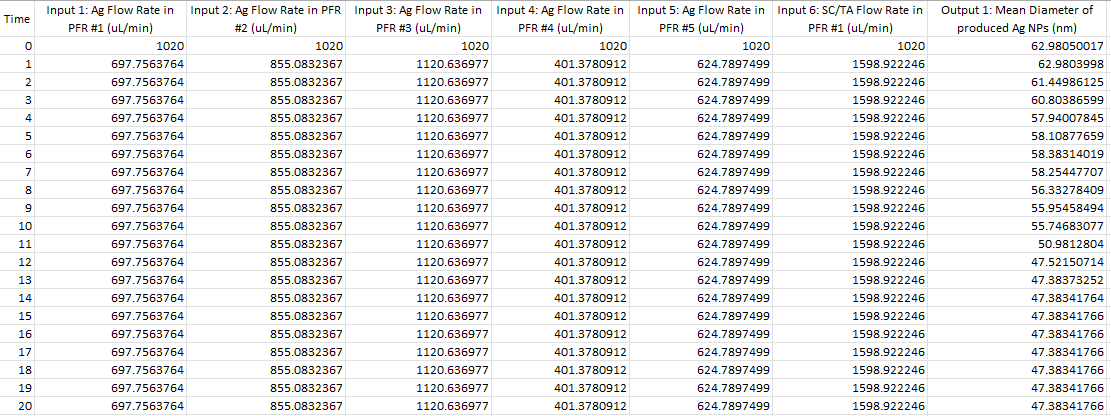

In [10]:
import_files_widget()

Output()

In [11]:
make_open_folder_loader_button(parse_col, folder="/content", index_col=0)

Output()

## **Visualize Data**

In [12]:
visualize_data_widget()

Output()

## **Data Preprocessing**

In [13]:
display(ui_pre, btn_preprocess, out_pre)

Button(button_style='success', description='Run pipeline', style=ButtonStyle())

Output()

## **RBFNN Training**

In [14]:
display(ui_rbf, btn_rbf_train, out_rbf)

Button(button_style='success', description='Train & Evaluate', style=ButtonStyle())

Output()

## **Save Models**

In [15]:
make_open_save_panel_button()